# Libraries

In [ ]:
!sudo apt-get update
!sudo apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev libopenal-dev timidity libwildmidi-dev unzip
!sudo apt-get install libboost-all-dev
!apt-get install liblua5.1-dev
!sudo apt-get install cmake libboost-all-dev libgtk2.0-dev libsdl2-dev python-numpy git
!git clone https://github.com/astronautas/vizdoom_gym.git
!python3 -m pip install -e vizdoom_gym/
!pip install pillow

'\n!sudo apt-get update\n!sudo apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev libopenal-dev timidity libwildmidi-dev unzip\n!sudo apt-get install libboost-all-dev\n!apt-get install liblua5.1-dev\n!sudo apt-get install cmake libboost-all-dev libgtk2.0-dev libsdl2-dev python-numpy git\n\n\n!git clone https://github.com/astronautas/vizdoom_gym.git\n!python3 -m pip install -e vizdoom_gym/\n!pip install pillow\n'

In [ ]:
import gym
import  vizdoom_gym
from  vizdoom_gym import  vizdoomgym
env = gym.make('VizdoomCorridor-v0')

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment VizdoomBasic-v0
  logger.warn(f"Overriding environment {spec.id}")
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment VizdoomCorridor-v0
  logger.warn(f"Overriding environment {spec.id}")
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment VizdoomDefendCenter-v0
  logger.warn(f"Overriding environment {spec.id}")
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment VizdoomDefendLine-v0
  logger.warn(f"Overriding environment {spec.id}")
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment VizdoomHealthGathering-v0
  logger.warn(f"Overriding environment {spec.id}")
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:542: UserWarnin

cannot import name 'rendering' from 'gym.envs.classic_control' (/usr/local/lib/python3.10/dist-packages/gym/envs/classic_control/__init__.py)


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
import numpy as np
from skimage.transform import resize
from gym.core import ObservationWrapper
from gym.spaces.box import Box
import numpy as np
from collections import namedtuple, deque
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import gym
import vizdoomgym
from gym import wrappers

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Pre-processing

In [ ]:
class PreprocessImage(ObservationWrapper):

    def __init__(self, env, height = 64, width = 64, grayscale = True, crop = lambda img: img):
        super(PreprocessImage, self).__init__(env)
        self.img_size = (height, width)
        self.grayscale = grayscale
        self.crop = crop
        n_colors = 1 if self.grayscale else 3
        self.observation_space = Box(0.0, 1.0, [n_colors, height, width])

    def observation(self, img):
        img = self.crop(img)
        img = resize(img, self.img_size)
        if self.grayscale:
            img = img.mean(-1, keepdims = True)
        img = np.transpose(img, (2, 0, 1))
        img = img.astype('float32') / 255.
        return img

Step = namedtuple('Step', ['state', 'action', 'reward', 'done'])

class NStepProgress:

    def __init__(self, env, ai, n_step):
        self.ai = ai
        self.rewards = []
        self.env = env
        self.n_step = n_step

    def __iter__(self):
        state = self.env.reset()
        history = deque()
        reward = 0.0
        while True:
            action = self.ai(np.array([state]))[0][0]
            next_state, r, is_done, _ = self.env.step(action)
            reward += r
            history.append(Step(state = state, action = action, reward = r, done = is_done))
            while len(history) > self.n_step + 1:
                history.popleft()
            if len(history) == self.n_step + 1:
                yield tuple(history)
            state = next_state
            if is_done:
                if len(history) > self.n_step + 1:
                    history.popleft()
                while len(history) >= 1:
                    yield tuple(history)
                    history.popleft()
                self.rewards.append(reward)
                reward = 0.0
                state = self.env.reset()
                history.clear()

    def rewards_steps(self):
        rewards_steps = self.rewards
        self.rewards = []
        return rewards_steps

class ReplayMemory:

    def __init__(self, n_steps, capacity = 10000):
        self.capacity = capacity
        self.n_steps = n_steps
        self.n_steps_iter = iter(n_steps)
        self.buffer = deque()

    def sample_batch(self, batch_size):
        ofs = 0
        vals = list(self.buffer)
        np.random.shuffle(vals)
        while (ofs+1)*batch_size <= len(self.buffer):
            yield vals[ofs*batch_size:(ofs+1)*batch_size]
            ofs += 1

    def run_steps(self, samples):
        while samples > 0:
            entry = next(self.n_steps_iter)
            self.buffer.append(entry)
            samples -= 1
        while len(self.buffer) > self.capacity:
            self.buffer.popleft()

# Building the AI

In [ ]:

class CNN(nn.Module):

    def __init__(self, number_actions):
        super(CNN, self).__init__()
        self.convolution1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 5)
        self.convolution2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3)
        #self.convolution3 = nn.Conv2d(in_channels = 96, out_channels = 96, kernel_size = 3, stride=2)
        self.convolution4 = nn.Conv2d(in_channels = 64, out_channels = 96, kernel_size = 3)
        self.convolution5 = nn.Conv2d(in_channels = 96, out_channels = 128, kernel_size = 3)
        #self.convolution6 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride=2)
        self.convolution7 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3,)
        #self.convolution8 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3)
        self.fc1 = nn.Linear(in_features = self.count_neurons((1, 256, 256)), out_features = 100)
        self.fc2 = nn.Linear(in_features = 100, out_features = 50)
        self.fc3 = nn.Linear(in_features = 50, out_features = number_actions)
        self.dropout = nn.Dropout(0.2)


    def count_neurons(self, image_dim):
        x = Variable(torch.rand(1, *image_dim))
        x = F.elu((self.convolution1(x)))
        x = F.elu(F.avg_pool2d(self.convolution2(x),2))
        #x = F.elu(F.max_pool2d(self.convolution3(x),3,2))
        x = F.elu((self.convolution4(x)))
        x = F.elu(F.avg_pool2d(self.convolution5(x),2))
        #x = F.elu(F.max_pool2d(self.convolution6(x),3))
        x = F.elu(F.avg_pool2d(self.convolution7(x),2))
        #x = F.elu(F.max_pool2d(self.convolution8(x),3))
        return x.data.view(1, -1).size(1)


    def forward(self, x):
        x = F.elu((self.convolution1(x)))
        x = F.elu(F.avg_pool2d(self.convolution2(x),2))
        #x = F.elu(F.max_pool2d(self.convolution3(x),3,2))
        x = F.elu((self.convolution4(x)))
        x = F.elu(F.avg_pool2d(self.convolution5(x),2))
        #x = F.elu(F.max_pool2d(self.convolution6(x),3,2))
        x = F.elu(F.avg_pool2d(self.convolution7(x),2))
        #x = F.elu(F.max_pool2d(self.convolution8(x),3,2))
        x = x.view(x.size(0), -1)
        x = F.elu(self.fc1(x))
        x = self.dropout(x)
        x = F.elu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

class SoftmaxBody(nn.Module):

    def __init__(self, T):
        super(SoftmaxBody, self).__init__()
        self.T = T

    def forward(self, outputs, number_actions=1):
        probs = F.softmax(outputs * self.T)
        actions = probs.multinomial(num_samples=number_actions)
        return actions


In [ ]:
class AI:

    def __init__(self, brain, body):
        self.brain = brain
        self.body = body

    def __call__(self, inputs):
        input = Variable(torch.from_numpy(np.array(inputs, dtype = np.float32)))
        output = self.brain(input)
        actions = self.body(output)
        return actions.data.numpy()

# Deep Convolutional Q-Learning

In [ ]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder

doom_env = PreprocessImage(gym.make('VizdoomCorridor-v0'), width = 256, height = 256, grayscale = True)
doom_env = gym.wrappers.RecordVideo (doom_env, "/videos")
number_actions = 7

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [ ]:
cnn = CNN(number_actions)
softmax_body = SoftmaxBody(T = 1.0)
ai = AI(brain = cnn, body = softmax_body)
#Experience Replay
n_steps = NStepProgress(env = doom_env, ai = ai, n_step = 10)
memory = ReplayMemory(n_steps = n_steps, capacity = 10000)

#Eligibility Trace
def eligibility_trace(batch):
    gamma = 0.99
    inputs = []
    targets = []
    for series in batch:
        input = Variable(torch.from_numpy(np.array([series[0].state, series[-1].state], dtype = np.float32)))
        output = cnn(input)
        cumul_reward = 0.0 if series[-1].done else output[1].data.max()
        for step in reversed(series[:-1]):
            cumul_reward = step.reward + gamma * cumul_reward
        state = series[0].state
        target = output[0].data
        target[series[0].action] = cumul_reward
        inputs.append(state)
        targets.append(target)
    return torch.from_numpy(np.array(inputs, dtype = np.float32)), torch.stack(targets)

#moving average on 100 steps
class MA:
    def __init__(self, size):
        self.list_of_rewards = []
        self.size = size
    def add(self, rewards):
        if isinstance(rewards, list):
            self.list_of_rewards += rewards
        else:
            self.list_of_rewards.append(rewards)
        while len(self.list_of_rewards) > self.size:
            del self.list_of_rewards[0]
    def average(self):
        return np.mean(self.list_of_rewards)
ma = MA(100)


# Training

In [ ]:
#loss = nn.MSELoss()
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr = 0.001)
nb_epochs = 20
for epoch in range(1, nb_epochs + 1):
    memory.run_steps(samples=200)
    for batch in memory.sample_batch(128):
        inputs, targets = eligibility_trace(batch)
        inputs, targets = Variable(inputs), Variable(targets)
        predictions = cnn(inputs)
        loss_error = loss(predictions, targets)
        optimizer.zero_grad()
        loss_error.backward()
        optimizer.step()
    rewards_steps = n_steps.rewards_steps()
    ma.add(rewards_steps)
    avg_reward = ma.average()
    print("Epoch: %s, Average Reward: %s" % (str(epoch), str(avg_reward)))

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:89: UserWarning: WARN: Disabling video recorder because environment <PreprocessImage<OrderEnforcing<StepAPICompatibility<PassiveEnvChecker<Vizd

# VISUALIZING

In [ ]:
import os
import cv2
import glob
import gym
import vizdoomgym
import matplotlib.pyplot as plt
from collections import Counter
from gym.wrappers import RecordVideo


In [ ]:
env = gym.make('VizdoomPredictPosition-v0')
action_num = env.action_space.n
print("Number of possible actions: ", action_num)
state = env.reset()
state, reward, done, info = env.step(env.action_space.sample())
print(state.shape)
env.close()

Number of possible actions:  3
(450, 800, 3)


/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` t

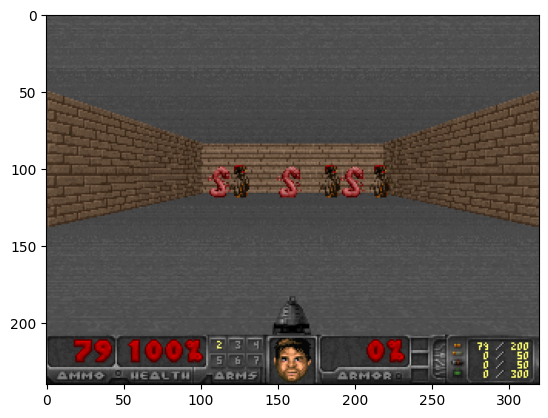

(240, 320, 3)


In [ ]:
observation = env.reset()
plt.imshow(observation)
plt.show()
print(observation.shape)

def wrap_env(env):
  env = RecordVideo(env, './vid')
  return env

### Running AI for one episode

In [ ]:
gym_env = PreprocessImage(env, width = 256, height = 256, grayscale = True)
gym_env = RecordVideo(gym_env, "videos")
environment = wrap_env(gym_env)
done = False
observation = environment.reset()
new_observation = observation
actions_counter = Counter()
prev_input = None
img_array=[]
while True:

    actions = cnn(Variable(Variable(torch.from_numpy(observation.reshape(1, 1, 256, 256)))))

    action = np.argmax(actions.detach().numpy(), axis=-1)
    actions_counter[str(action)] += 1
    environment.render()
    observation = new_observation
    new_observation, reward, done, _ = environment.step(action)
    img_array.append(new_observation)
    if done:
        break
environment.close()

/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/vid folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


### Visualized Result

In [ ]:
folder_name = "gameplay_frames"
video_name = "agent_gameplay.avi"

if not os.path.exists(folder_name):
    os.makedirs(folder_name)

for i in range(len(img_array)):
    plt.imsave("{}/{}_frame.jpg".format(folder_name, i), img_array[i].reshape(256, 256))

files = glob.glob(os.path.expanduser("{}/*".format(folder_name)))
frames_array = []

for filename in sorted(files, key=lambda t: os.stat(t).st_mtime):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    frames_array.append(img)

out = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

for i in range(len(frames_array)):
    out.write(frames_array[i])

out.release()